# Supplementary Figures for *Luo et al. 2020*

(*A high-resolution HLA reference panel capturing global population diversity enables multi-ethnic fine-mapping in HIV host response*)


**Code for reproducing supplementary figures in the manuscript**

For any question please contact the first author Yang Luo: yangluo@broadinstitute.org

## loading up libraries and presettings

In [1]:
#Load libraries
library(ggplot2)
library(reshape2)
library(reticulate)
library(repr)
library(patchwork)
library(plyr)
library(scales)
library(RColorBrewer)
library(dplyr)
library(data.table)
library(ggthemes)
library(ggsci)
library(rsvd)
library(tidyr)
library(ggrepel)
library(umap)
library(gridExtra)
library(cowplot)
library(plotrix)
library(ggpubr)
library(grid)
library(corrplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following objects are masked from ‘package:reshape2’:

    dcast, melt



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

****************************************

In [2]:
# set global plotting parameters
theme_set(theme_bw() + theme(text = element_text(size=20, family = "sans")))

options(repr.plot.width = 10, repr.plot.height = 7)

#pop_colors <- c("black", "#E69F00","#56B4E9","#D55E00","#009E73")
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#D55E00","#009E73")

pop_labels <- c("Admixed African","East Asian","European","Latino", "South Asian")

#Calc color palette (discrete)
gene_colors <- c("A"="#004586", "B" = "#ff420e", "C"="#ffd320", 
                 "DQA1" = "#579d1c", "DQB1" = "#7e0021", "DRB1" = "#83caff","DPA1" = "#314004", "DPB1" = "#aecf00"  )


## HLA*LA typing accuracy (SF1)

In [4]:
allele.summary <- read.table("../data/Ggroup_allele_summary.txt.gz",h=T,stringsAsFactors = F)

allele.summary$Gene <- sapply(strsplit(allele.summary[,1], "\\*"), "[[", 1)


### Japanese inferred G-group accuracy (N = 288) (SF1a)

[1] 85 13

Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text_repel).”


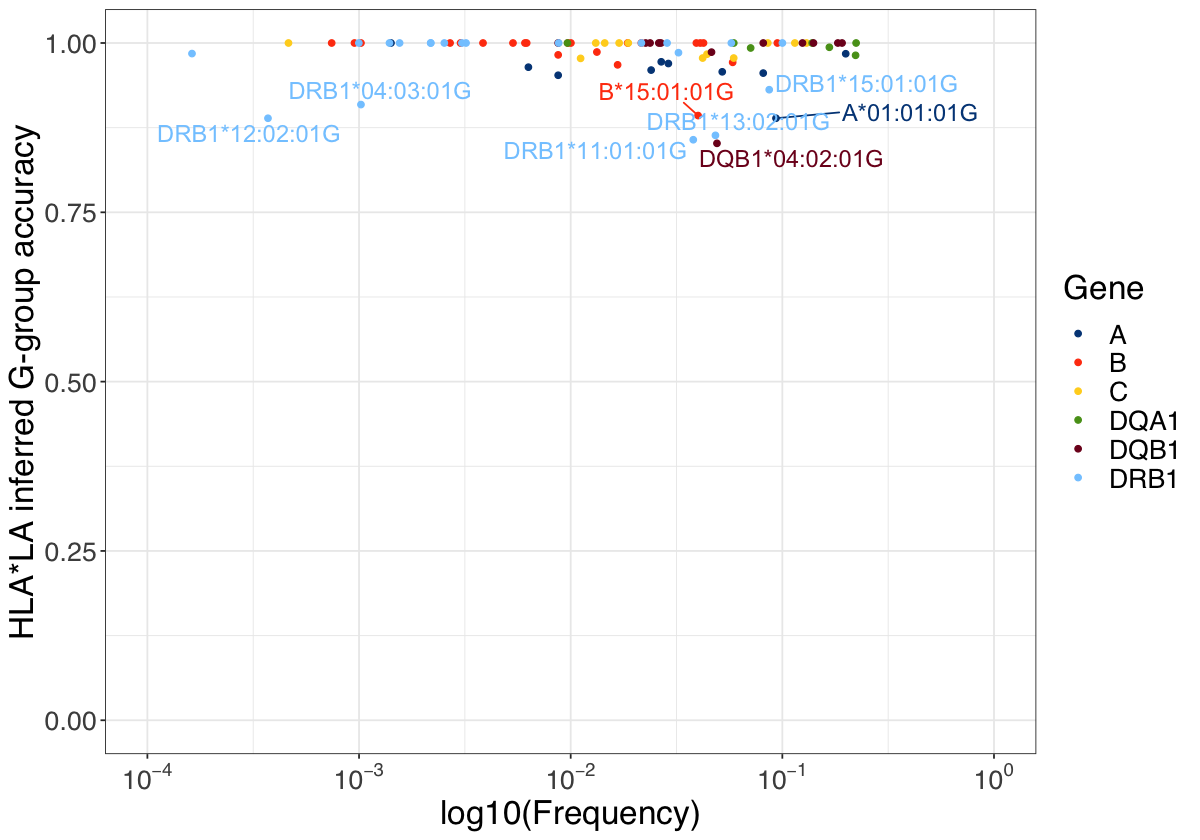

In [6]:
jpn <- allele.summary[!is.na(allele.summary$JPNaccuracy),]
jpn$label <- ifelse(jpn$JPNaccuracy<0.95,jpn$Allele,"")

gold_standard <- read.table("../data/JPN_gold_standard_Ggroups.txt",h=F)
gs.n <- unique(c(gold_standard[,7:22])) %>% unlist() %>% table() %>% as.data.frame()
names(gs.n) <-  c("Allele","n")

jpn$n <- gs.n[match(jpn$Allele,gs.n$Allele),2]
df <- jpn %>% filter(n>=5)
dim(df)
p <- ggplot(df,aes(x=log10(Freq),y=JPNaccuracy,label=label, color=Gene)) + geom_point() 

p <- p + ylab("HLA*LA inferred G-group accuracy") + ylim(0,1)+
 scale_x_continuous(name = "log10(Frequency)",breaks=c(-4,-3, -2, -1,0),limits=c(-4,0),
                       labels=c(expression(10^-4),expression(10^-3),expression(10^-2),expression(10^-1),expression(10^0)))

p + geom_text_repel(size=5, show.legend = FALSE) + scale_colour_manual( values = gene_colors)
ggsave("../figs/SF1a_JPN_HLA_LA_accuracy.pdf",width=10,height=7)

### HLA*LA typing accuracy in 1KG (SF1b)

Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_text_repel).”


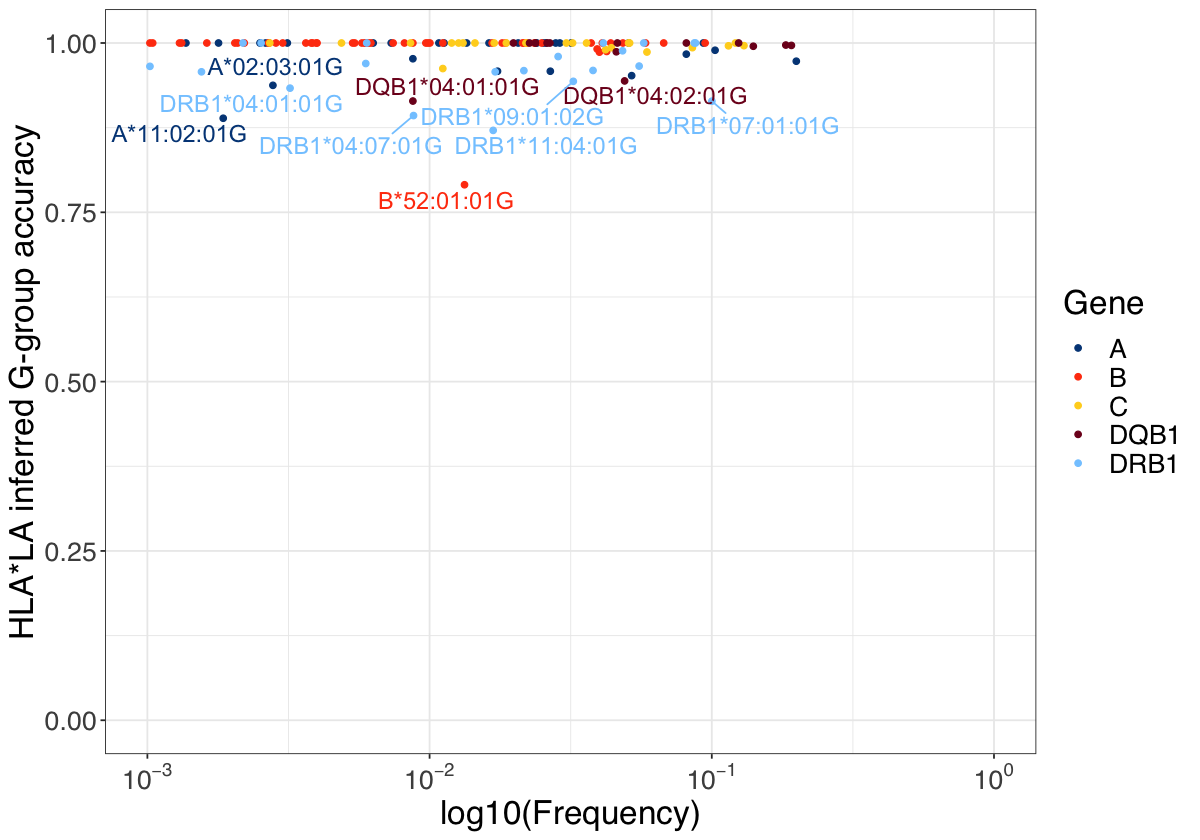

In [9]:
g1k <- allele.summary[!is.na(allele.summary$G1Kaccuracy),]
g1k$label <- ifelse(g1k$G1Kaccuracy<0.95,g1k$Allele,"")

g1k.goldstandard.ggroup <- read.table("../data/G1k_gold_standard_Ggroups.txt",header = T,stringsAsFactors = F)

gs.n <- unique(c(g1k.goldstandard.ggroup[,2:10])) %>% unlist() %>% table() %>% as.data.frame()

names(gs.n) <-  c("Allele","n")

g1k$n <- gs.n[match(g1k$Allele,gs.n$Allele),2]
df <- g1k %>% filter(n>=5)

p <- ggplot(df,aes(x=log10(Freq),y=G1Kaccuracy,label=label, color=Gene)) + geom_point() 

p <- p + ylab("HLA*LA inferred G-group accuracy")+ ylim(0,1) + 
 scale_x_continuous(name = "log10(Frequency)",breaks=c(-3, -2, -1,0),limits = c(-3,0),
                       labels=c(expression(10^-3),expression(10^-2),expression(10^-1),expression(10^0)))

p + geom_text_repel(size=5, show.legend = FALSE) +
    scale_colour_manual(values = gene_colors)

ggsave("../figs/SF1b_G1K_HLA_LA_accuracy.pdf",width=10,height=7)



## 1000G diversity (SF2)

###  PC (SF2a)


In [28]:
## Get data (pairwise IBD using beagle)
ibd <- read.table("../data/deep1000Gibd.txt.gz", row.names = 1, header = T, stringsAsFactors = F)
sampleInfo <- read.table("../data/g1k_samples.txt",header = T, stringsAsFactors = F )
mhc <- ibd[row.names(ibd) %in% sampleInfo$sample,names(ibd) %in% sampleInfo$sample]
mhc_scale <- scale(mhc)
# calculate PCs
mhc.pca <- rsvd(as.matrix(mhc_scale), k=30)
x <- rpca(as.matrix(mhc_scale), k=30)

In [35]:

summary(x)[3,1:2]


PC1   PC2 
0.087 0.060

[1] 0.04369601

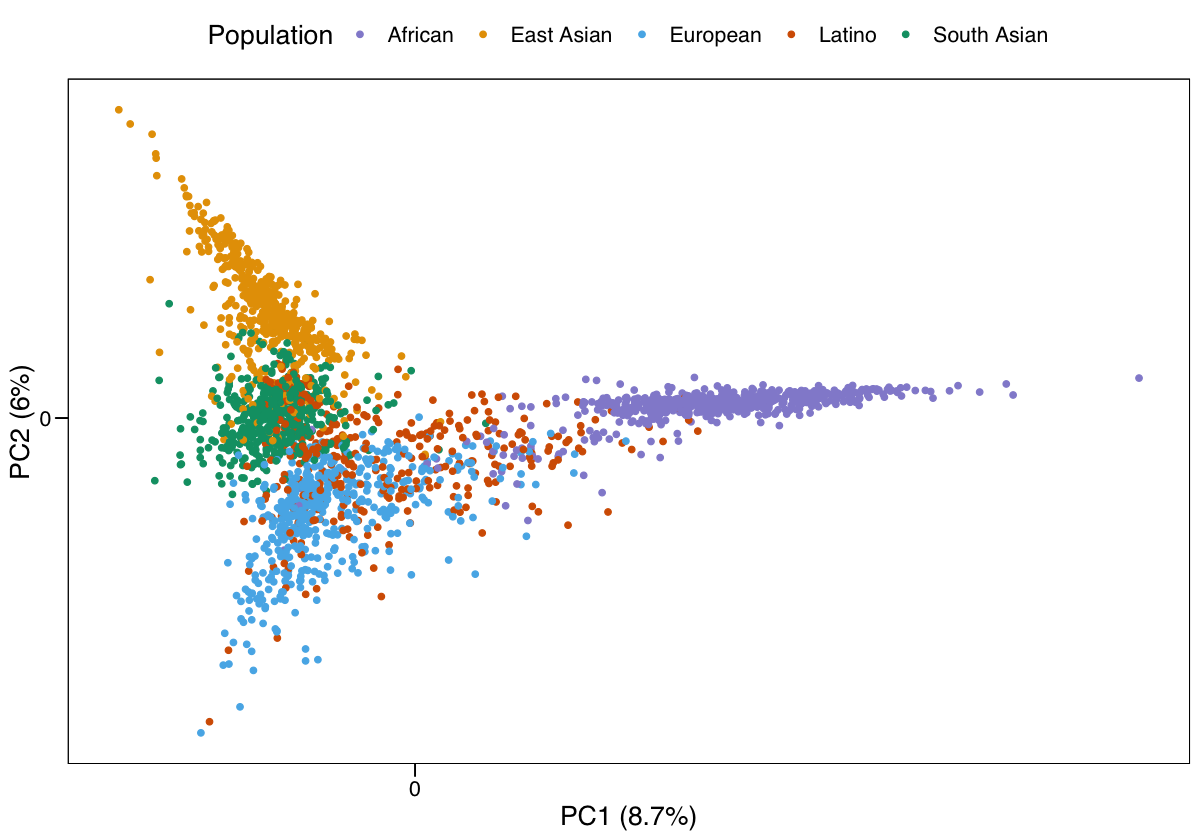

In [36]:

varexp <- summary(x)[3,1:2]*100

dfplt <- as.data.frame(mhc.pca$u[,1:5])

dfplt$ancestry <- sampleInfo[match(row.names(ibd),sampleInfo$sample),]$super_pop

dfplt[dfplt$ancestry=="AMR",]$ancestry <- "LAT"
g1k.pc.plt <- ggplot(dfplt,aes(V1,V2,colour=ancestry))+geom_point()
g1k.pc.plt <- g1k.pc.plt + scale_color_manual(values = pop_colors,
                                              name="Population",labels=c("African","East Asian","European","Latino","South Asian")) + 
theme_base() +
    xlab(paste("PC1 (",round(varexp[1],2),"%)",sep=""))+ylab(paste("PC2 (",round(varexp[2],2),"%)",sep=""))


g1k.pc.plt <- g1k.pc.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans")) 

g1k.pc.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

ggsave(filename = "../figs/SF2a_G1K-PCA.pdf",height=8,width=9)

### UMAP (SF2b)

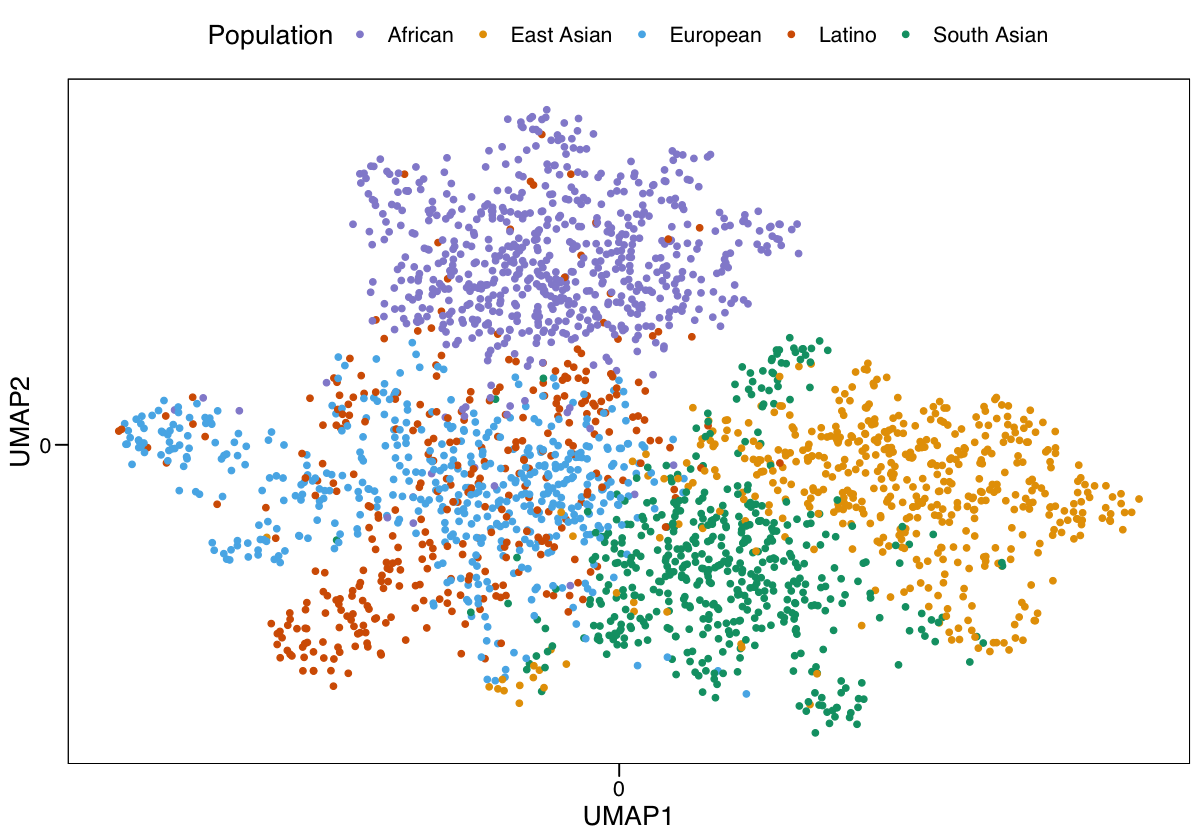

In [15]:
g1k.umap <- umap(mhc_scale,min_dist=0.9,n_neighbors=250)
umap.plt <- data.frame(g1k.umap$layout)

umap.plt $ancestry <- sampleInfo[match(row.names(umap.plt ),sampleInfo$sample),]$super_pop
umap.plt[umap.plt$ancestry=="AMR",] $ancestry <- "LAT"

g1k.umap.plt <- ggplot(umap.plt ,aes(X1,X2,colour=ancestry))+geom_point()
g1k.umap.plt <- g1k.umap.plt + scale_color_manual(values = pop_colors,
                                  name="Population",labels=c("African","East Asian","European","Latino","South Asian")) + 
theme_base() + xlab("UMAP1") + ylab("UMAP2")

g1k.umap.plt <- g1k.umap.plt + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(family = "sans"))
g1k.umap.plt + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

ggsave(filename = "../figs/SF2b_G1K-UMAP.pdf",height=8,width=9)

## G-group diversity (SF3)

In [40]:
dat<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
dim(dat)
dat[dat$ethnicity == "missing", ]$ethnicity <- "AFR"
# summary of total ancestry 
table(dat$ethnicity)

# Total number of G-group alleles within each ancestry
ddply(dat,~ethnicity,summarise,count=length(unique(c(A1,A2,B1,B2,C1,C2,DQA11,DQA12,DQB11,DQB12,DRB11,DRB12))))
#head(dat)

[1] 21546    22


    AFR     EAS     EUR     LAT missing     SAS 
   7849    2069   10187     952       0     489 

ethnicity,count
<fct>,<int>
AFR,323
EAS,247
EUR,307
LAT,256
SAS,184


In [41]:
#creat frequency table

create_table<-function(dat=JPN2,genes=c("A","B","C","DQA1","DQB1","DRB1", "DPA1","DPB1")){
    out<-NULL
    for (gene in genes){
        x<-subset(dat,select=c(paste(gene,"1",sep="")))
        y<-subset(dat,select=c(paste(gene,"2",sep="")))
        df<-na.omit(cbind(x,y))
        frq<-data.frame(table(as.vector(unlist(df[,1:2]),mode='character'))/(nrow(dat)*2))
        frq$Gene<-gene
        out<-rbind(out,frq)
    }
    return(data.frame(out))
}

In [45]:
all <- NULL
frq <- create_table(dat=dat[dat$ethnicity=="LAT",])
frq$Ethnicity<-"LAT"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EUR",])
frq$Ethnicity<-"EUR"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="AFR",])
frq$Ethnicity<-"AA"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="EAS",])
frq$Ethnicity<-"EAS"
all<-rbind(all,frq)

frq<-create_table(dat=dat[dat$ethnicity=="SAS",])
frq$Ethnicity<-"SAS"
all<-rbind(all,frq)

#head(all)
#define top most frequent alleles
df2<-all %>% group_by(Gene,Ethnicity) %>% top_n(2, Freq) %>% arrange(Gene,Ethnicity,desc(Freq))
others<-setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene, Ethnicity)] 

df3<-rbind(all[all$Var1 %in% df2$Var1,],others)
count<-aggregate(df3$Var1, list(df3$Gene),unique)


TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

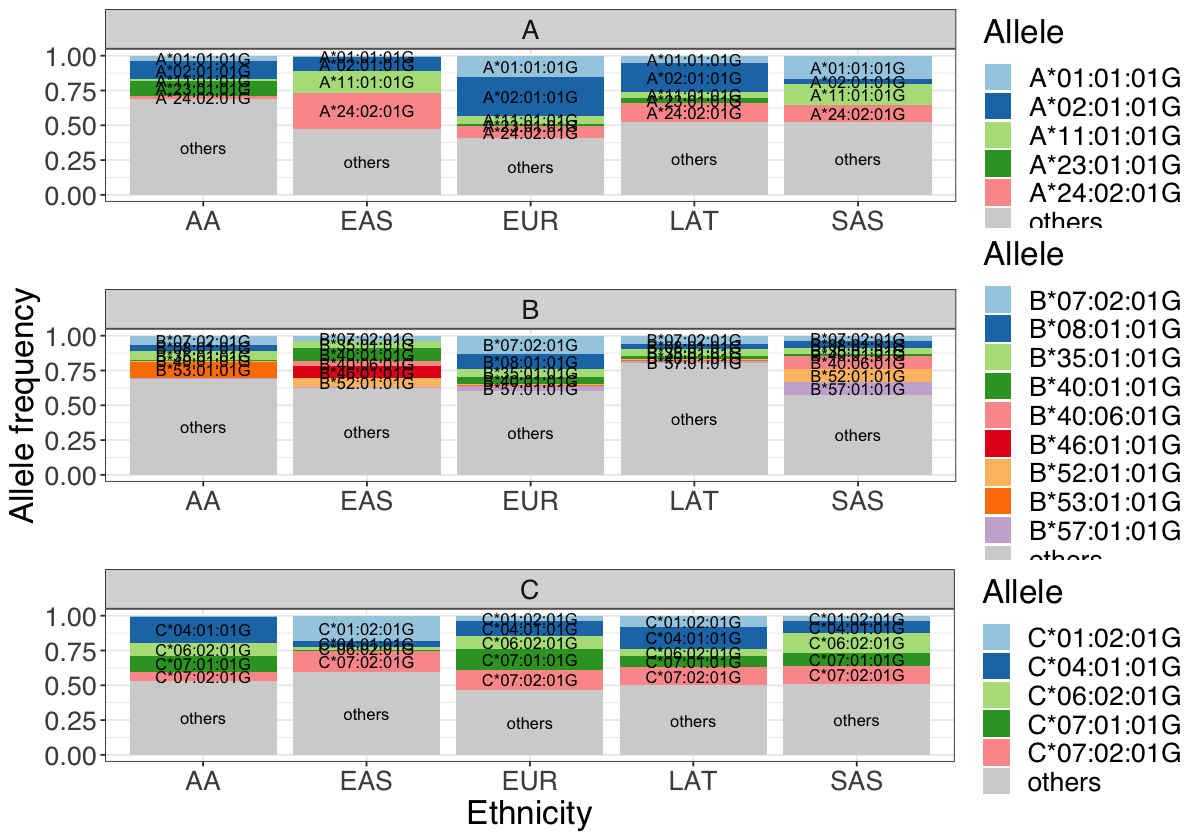

In [48]:
Ggroup <- split(df3, f = df3$Gene)

Ggroup$A$Label <- ifelse(Ggroup$A$Freq > 1e-2,as.character(Ggroup$A$Var1),"")

p1 <- ggplot(Ggroup$A,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$B$Label <- ifelse(Ggroup$B$Freq > 1e-2,as.character(Ggroup$B$Var1),"")
p2 <- ggplot(Ggroup$B,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:14],"lightgrey"))+
     ylab("Allele frequency") + xlab("")

Ggroup$C$Label <- ifelse(Ggroup$C$Freq > 1e-2,as.character(Ggroup$C$Var1),"")
p3 <- ggplot(Ggroup$C,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[15:19],"lightgrey"))+ ylab("")

p <- grid.arrange(p1, p2,p3 ,ncol=1)
p
ggsave(p,filename = "../figs/SF3_G-group_classI_freq.pdf",width=8,height=11)


TableGrob (5 x 1) "arrange": 5 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]
5 5 (5-5,1-1) arrange gtable[layout]

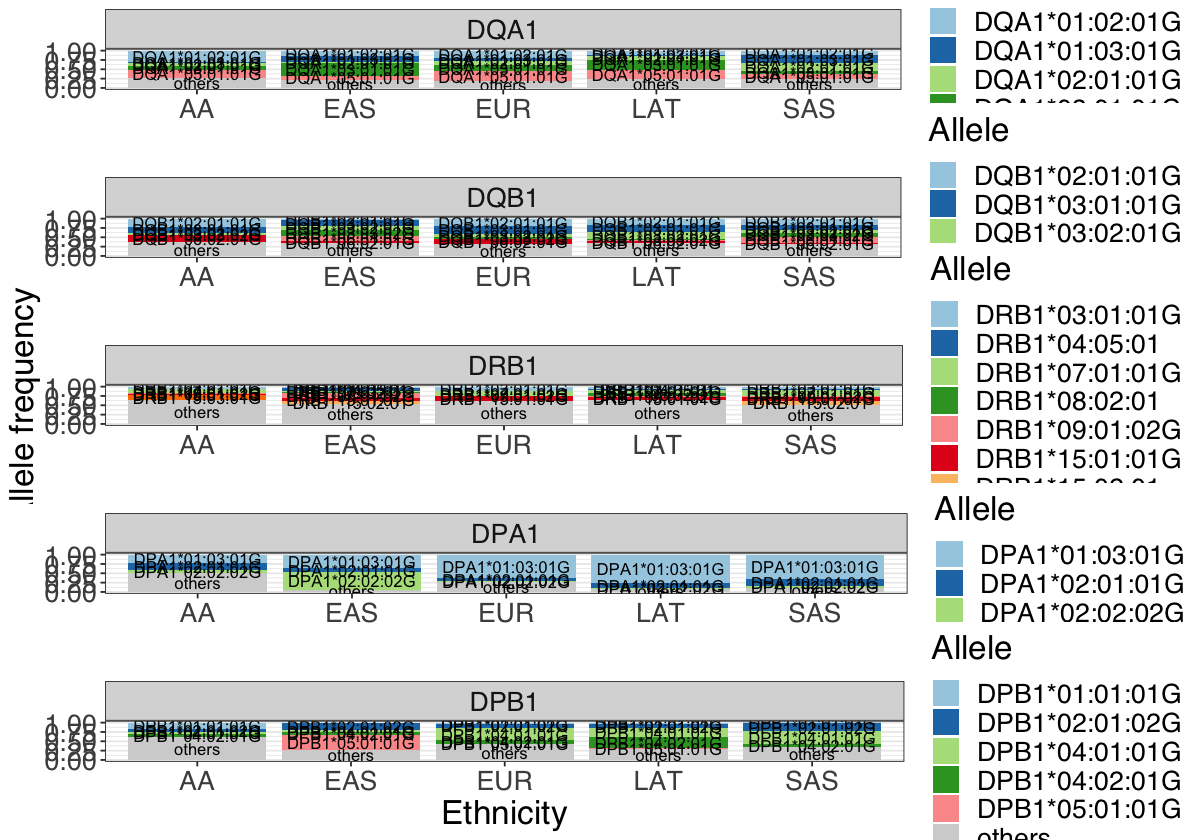

In [50]:
##  Class II
Ggroup <- split(df3, f = df3$Gene)

Ggroup$DQA1$Var1 <- ifelse(Ggroup$DQA1$Var1=="DQA1*02:01","DQA1*02:01:01G",as.character(Ggroup$DQA1$Var1))
Ggroup$DQA1$Label <- ifelse(Ggroup$DQA1$Freq > 1e-2,as.character(Ggroup$DQA1$Var1),"")
p1 <- ggplot(Ggroup$DQA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey")) + 
    ylab("")+ xlab("")


Ggroup$DQB1$Label <- ifelse(Ggroup$DQB1$Freq > 1e-2,as.character(Ggroup$DQB1$Var1),"")
p2 <- ggplot(Ggroup$DQB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:11],"lightgrey"))+
     ylab("") + xlab("")

Ggroup$DRB1$Label <- ifelse(Ggroup$DRB1$Freq > 1e-2,as.character(Ggroup$DRB1$Var1),"")
p3 <- ggplot(Ggroup$DRB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + xlab("")+
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[6:13],"lightgrey"))+ ylab("Allele frequency")

Ggroup$DPA1$Label <- ifelse(Ggroup$DPA1$Freq > 1e-2,as.character(Ggroup$DPA1$Var1),"")
p4 <- ggplot(Ggroup$DPA1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:3],"lightgrey"))+ ylab("") + xlab("")
Ggroup$DPB1$Label <- ifelse(Ggroup$DPB1$Freq > 1e-2,as.character(Ggroup$DPB1$Var1),"")
p5 <- ggplot(Ggroup$DPB1,aes(x=Ethnicity,y=Freq,fill=Var1))+geom_bar(stat='identity')+
    facet_wrap(~Gene) + 
    geom_text(aes(label=Label), position=position_stack(vjust = 0.5), size = 3.5) + 
    scale_fill_manual(name="Allele",values=c(cbPalette[1:5],"lightgrey"))+ ylab("")

    
p <- grid.arrange(p1, p2,p3,p4 ,p5,ncol=1)
p
ggsave(p,filename = "../figs/SF3_G-group_classII_freq.pdf",width=12,height=16)


## Heterogeneity of observed common G-group alleles (SF4)

In [51]:
allele.summary <- read.table("../data/Ggroup_allele_summary.txt.gz",h=T,stringsAsFactors = F)
allele.summary$Gene <- sapply(strsplit(allele.summary[,1], "\\*"), "[[", 1)

# alleles show significant difference among population groups (stratified by frequency)

n <- nrow(allele.summary[allele.summary$Freq >= 0.005,])

allele.summary$label <- ifelse(allele.summary$Pval>=0.05/n,allele.summary$Allele,"")
allele.summary[allele.summary$Allele=="B*53:01:01G",]$label <- "B*53:01:01G"
# to make all <10^-300 points to be 300 for plotting
allele.summary$P <- ifelse(-log10(allele.summary$Pval)>=300, 1e-300, allele.summary$Pval)


[1] 175

###  the log10(frequency) of all G-group alleles (SF4a)

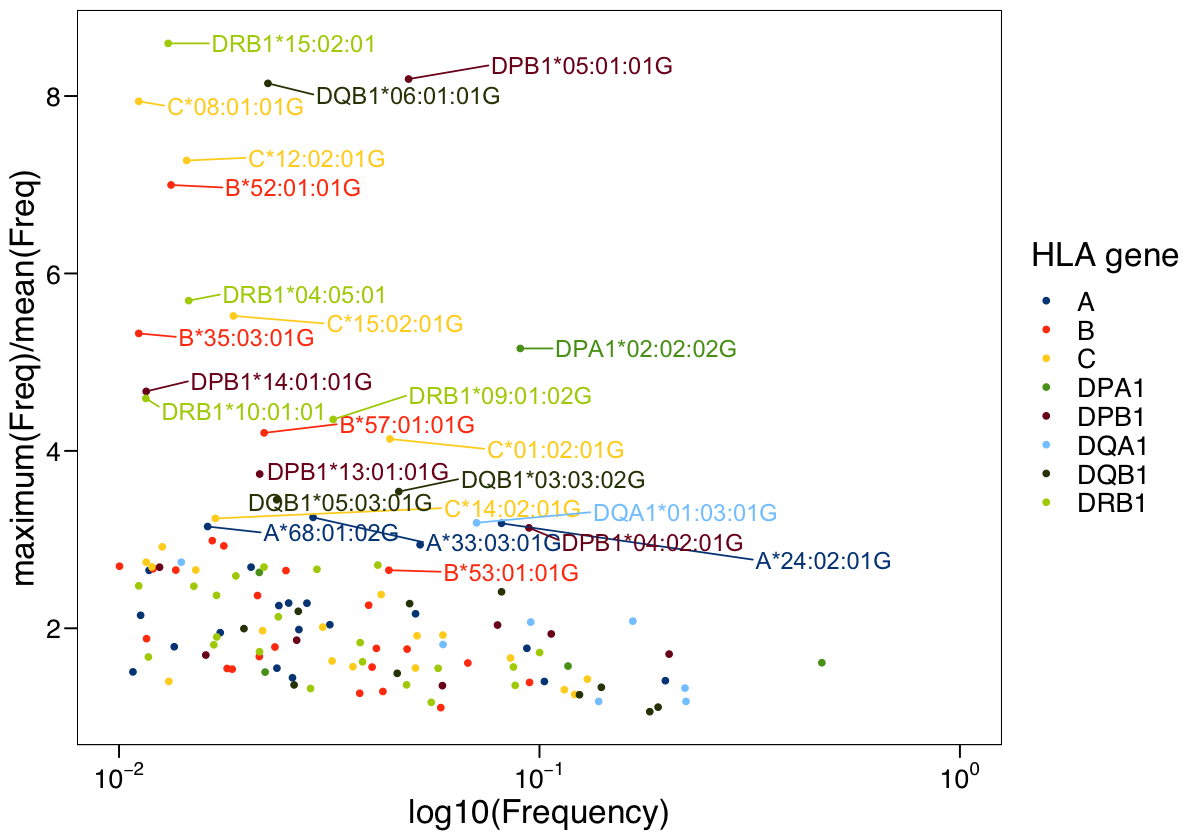

In [56]:
allele.summary[is.na(allele.summary)] <- 0
df <- allele.summary %>% rowwise() %>% mutate(maxFreq=max(EURfreq,AAfreq,LATfreq,SASfreq,EASfreq)) %>%
    mutate(diffFreq = maxFreq/Freq)


df$label <- ifelse(df$diffFreq>3,df$Allele,"")
df[df$Allele=="B*53:01:01G",]$label <- "B*53:01:01G"

p <- ggplot(df %>% filter(Freq>0.01),aes(log10(Freq),diffFreq, color = Gene,
                                                     label=label))+geom_point() + theme_base()  

p <- p + scale_x_continuous(name = "log10(Frequency)",breaks=c(-2, -1, 0),
                       labels=c(expression(10^-2),expression(10^-1),expression(10^0)),
                            limits = c(-2,0))

p <- p + theme(plot.background=element_blank(),
                        text = element_text(size=20, family = "sans")) +
 scale_y_continuous(name = "maximum(Freq)/mean(Freq)") 


p + scale_colour_calc(name="HLA gene") + geom_text_repel(segment.size  = .5,nudge_x = 0.3,
                                                         size=5, show.legend = FALSE) 

ggsave("../figs/SF4a_Ggroup_maxvsmeanfreq_by_freq.pdf",width=10,height=7)

### the -log10(P-value) of chi-square statistics obtained from a 3x5  contingency table (SF4b)

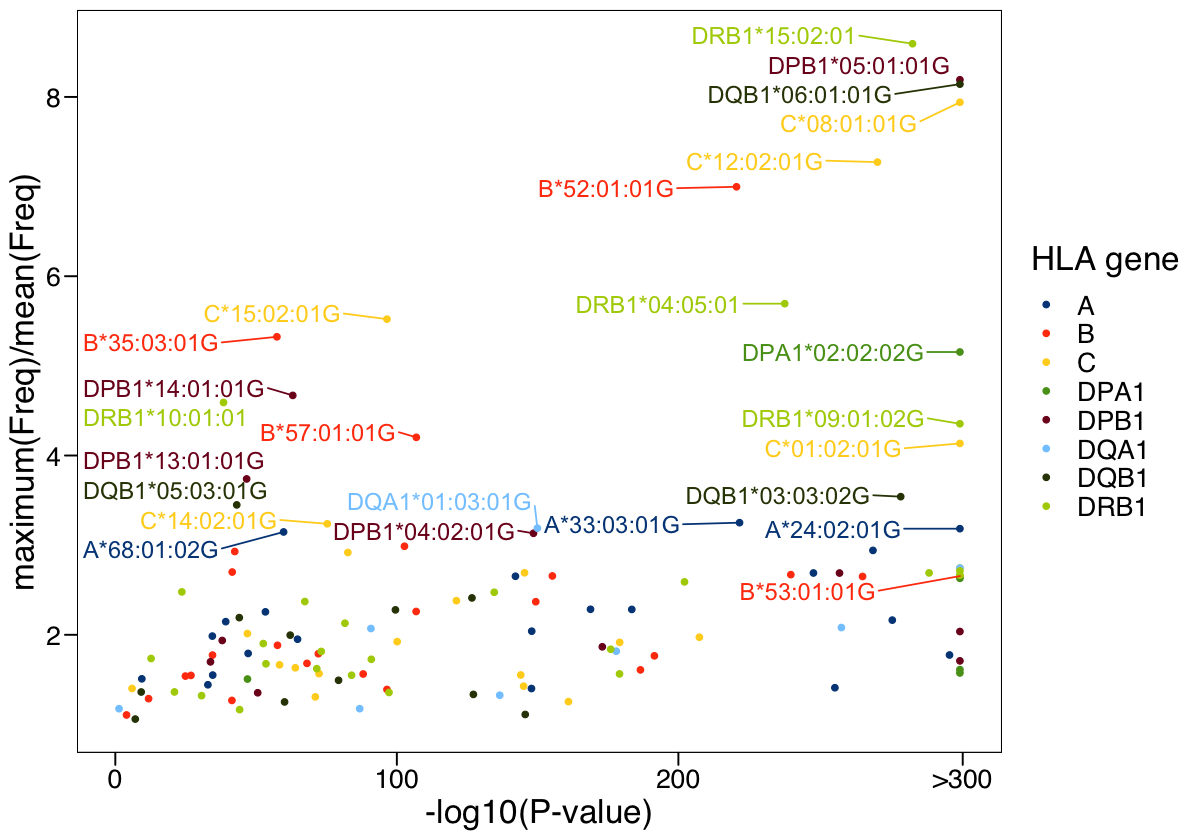

In [55]:
p <- ggplot(df %>% filter(Freq>0.01),aes(-log10(P),diffFreq, color = Gene,
                                                     label=label))+geom_point() + theme_base()  


p <- p + theme(plot.background=element_blank(),
                        text = element_text(size=20, family = "sans")) +
 scale_y_continuous(name = "maximum(Freq)/mean(Freq)") +
 scale_x_continuous(name = "-log10(P-value)",breaks=c(0,100,200,301),labels = c(0,100,200,">300")) 



p + scale_colour_calc(name="HLA gene") + geom_text_repel(segment.size  = .5, nudge_x = -45,
                                                         size=5,show.legend = FALSE) 

ggsave("../figs/SF4b_Ggroup_maxvsmeanfreq_by_pval.pdf",width=10,height=7)


## Number of observed G-group alleles (SF5)

[1] 1532   13

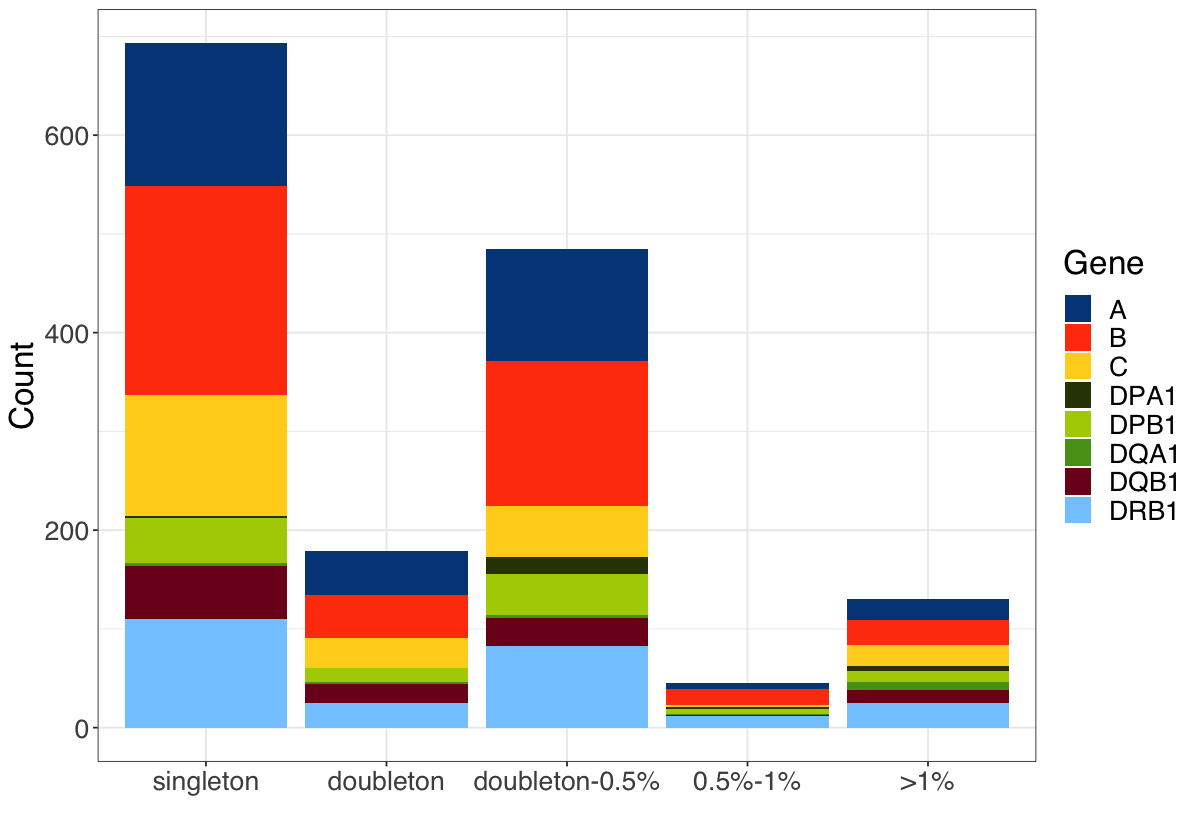

In [57]:
n <- 21546 # totoal number of individuals

freq.bin <- c(0,1/n/2,1/n,0.005,0.01,1)

x <- allele.summary %>%
  group_by(group = cut(Freq, breaks = freq.bin))
dim(allele.summary)

count.df <- x %>% group_by(group,Gene) %>% count(group)

p <- ggplot(count.df,aes(x=group, y=n, fill=Gene)) + geom_bar(stat='identity') +
    theme_bw() + xlab("") + ylab("Count")

p +  scale_x_discrete(labels=c("singleton", "doubleton",
                               "doubleton-0.5%","0.5%-1%",">1%")) +
    theme(text = element_text(size=20, family = "sans")) +  scale_fill_manual(values = gene_colors)

ggsave('../figs/SF6_Ggroup_freq_count.pdf',width=10,height=7)


## Overall G-group diversity in eight HLA genes (SF6)

In [ ]:
all <- create_table(dat=Ggroup[!is.na(Ggroup$ethnicity),])

#define top most frequent alleles
n <- 5
df2 <- all %>% group_by(Gene) %>% top_n(n, Freq) %>% arrange(Gene,desc(Freq))
others <- setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene)] %>% arrange(Gene,desc(Freq))
others$order <- n+1

df3 <- df2 %>% group_by(Gene) %>% arrange(Gene,desc(Freq))
df3$order <- rep(c(1:n),8)


df4 <- rbind(data.frame(df3),data.frame(others[,names(df3)]))

freq.plt <- ggplot(df4,aes(x=Gene,y=Freq,fill=as.factor(order)))+geom_bar(stat='identity')+scale_y_continuous(label=percent)+
    geom_text(aes(label=Var1), position=position_stack(vjust = 0.5), size=3)
freq.plt <- freq.plt + theme_base()+theme(legend.position = "none" ) + scale_fill_manual(values=c(brewer.pal(5,"Paired"),"grey"))

options(repr.plot.width = 10, repr.plot.height = 9)


freq.plt <- freq.plt + xlab("") + ylab("Allele frequency")

freq.plt  <- freq.plt +  theme(legend.position="none",
                        plot.background=element_blank(),
                        text = element_text(family = "sans"))
freq.plt
ggsave(filename = "../figs/Fig1c-freq.png",width=10,height=7)